In [147]:
import numpy as np
import math as math
import time

# import collections

import cv2 as cv
from imageio import imread
import matplotlib.pyplot as plt


In [148]:
# credit: I consulted opencv's documentation: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

# 1. figure out how to extract interest point operators
# 2. figure out how to compute the corresponding SIFT descriptors.

# reference_image = imread('panda/panda_reference.jpeg')
# reference_image = imread('stopsign/stop-reference.jpg')

# reference_image = imread('stopsign/stop-reference.jpg')
# input_image = imread('stopsign/stop1.jpg')


# sift = cv.SIFT_create()

# ref_keypoints, ref_descriptors = sift.detectAndCompute(reference_image, None)
# keypoints, descriptors

# 3. Implement robust matching of SIFT descriptors
# credit: I consulted opencv's documentation: https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
# this finished step 1 of the outline


def matching (input_image,reference_image, match_threshold=0.8):
    sift = cv.SIFT_create(contrastThreshold=0.04) 
    # nfeatures=, edgeThreshold=0.2
    # greater edgethreshold, 
    ref_keypoints, ref_descriptors = sift.detectAndCompute(reference_image, None)
    keypoints, descriptors = sift.detectAndCompute(input_image, None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors,ref_descriptors,k=2)

    # Apply ratio test
    good = []
    good_ref = []
    good_match = []
    # apply ratio test
    for m,n in matches:
        if m.distance < match_threshold * n.distance:
            good.append(keypoints[m.queryIdx])
            good_ref.append(ref_keypoints[m.trainIdx])
            good_match.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img = cv.drawMatchesKnn(input_image, keypoints, reference_image, ref_keypoints,good_match, None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img),plt.show()
    return good, good_ref

# matching(input_image=input_image, reference_image=reference_image, match_threshold=0.8)

In [149]:
#credit: http://amroamroamro.github.io/mexopencv/matlab/cv.SIFT.detectAndCompute.html for understanding keypoints and descriptors 
#4.find the corners of the bounding rectangles in the reference image
# then use this to find the bounding rectangles in the input image
# observe the equation is given by 
# transformation = point + scale_input/scale_ref * rotation
# where rotation is given by offset * rotation matrix of the difference of angles
# the result is the "corner" of input image (lower left, upper right of the image) that will get voted on in step3.
# this provides the query that supports the lookup operation described in step 2 
def transform_bounding_corners (reference_image, input_keypoint, ref_keypoint):
    # compute the height and width of the image
    height, width = reference_image.shape[:2]

    # compute the coordinates of upper right and lower left for the parameterized bounding box
    # upper_right = np.array((width, height))
    # lower_left = np.array((0,0))
    ### image y axis is inverted, hence
    upper_right = [width, 0]
    lower_left = [0,height]
    # upper_right = np.array((width, 0))
    # lower_left = np.array((0,height))
    
    # for hough transform
    corners = np.array([upper_right, lower_left])
    offset = corners - ref_keypoint.pt
    angle_radian = np.deg2rad(input_keypoint.angle - ref_keypoint.angle)
    rotation_matrix = np.array([
        [math.cos(angle_radian), -math.sin(angle_radian)],
        [math.sin(angle_radian),math.cos(angle_radian)]
    ]
    )
    rotate = offset @ rotation_matrix.T
    
    transformation = input_keypoint.pt + (input_keypoint.size / ref_keypoint.size) * rotate
    return transformation

In [150]:
#5. apply Hough Transform (counting votes)
# I consulted https://numpy.org/doc/stable/reference/generated/numpy.histogram.html for accumulator array
# I consulted https://github.com/RuolinZheng08/ttic31040-computer-vision/tree/main/project for understanding the voting scheme.
# we use corners as parameters for votes
# filter out key points using hough transform by voting on the corners


# this finishes step 3 of the outline by iteratively looking up the query and counting the votes. 
def hough_transform (reference_image, input_keypoints, ref_keypoints, num):
    #initialize the vote counter 
    corners = []
    length = 0
    #flatten the coordinate of the corners
    for input_keypoint, ref_keypoint in zip(input_keypoints, ref_keypoints):
        corners.append(transform_bounding_corners(reference_image,input_keypoint=input_keypoint, ref_keypoint=ref_keypoint).flatten())
        length = length + 1
    corners = np.array(corners)
     
    # assert len(corners) == 4

    # let each coordinate vote on the range of vertices to be included
    # to find multiple, after each iteration, eliminate the most counted coordinates
    # 
    votes = []
    for i in range(corners.shape[1]): 
        _,bins = np.histogram(corners[:,i], bins = num)
        vote_i = np.digitize(corners[:,i], bins, right=False)
        votes.append(vote_i)
    votes = np.array(votes).T
    # now we have collected the  voting for the range of the corners (how do I make this precise instead of the range?)
    # count the voting of the ranges, then select the points with the mostly selected range.


    # counter = collections.Counter(vote)
    # print(counter)
    
    counter = counting_vote(tuple(tuple(vote) for vote in votes))

    
    # print("counter:", counter)
    print("# of keypoints:", length)
    common_list = []
    max_size = max(counter.values())
    minimum_threshold = length / 5 # need to tune this parameter
    if max_size < minimum_threshold:
        return [], []
    
    # print("max_size:", max_size)
    most_common = np.array(max(counter, key = counter.get))

    for vote_list, count in counter.items():
        # if count > (length/4): # a terrible threshold
        if count > max_size/2: # still not a really good threshold. tuning parameters for better result.
            common_list.append(vote_list)
            
    

    print("common:", common_list)
    

    # one instance case
    print("most_common:, ",most_common)
    indices = []
    
    for i in range(votes.shape[0]):
        if votes.tolist()[i] == most_common.tolist():
            indices.append(i)
    
    input_points = []
    ref_points = []
    for i in indices:
        input_points.append(input_keypoints[i].pt)
        ref_points.append(ref_keypoints[i].pt)
    input_points = np.array(input_points).reshape(-1,1,2)    
    ref_points = np.array(ref_points).reshape(-1,1,2)
    
    # multiple instance case
    indicess = []
    # indices = []
    for k in range(len(common_list)):
        one_index_list = []
        for i in range(votes.shape[0]):
            if votes.tolist()[i] == list(common_list[k]):
            # if votes.tolist()[i] == common_list[k].tolist():
                one_index_list.append(i)
        indicess.append(one_index_list)
            
    

    # how do i reshape this?
    
    input_points_multiple = []
    ref_points_multiple = []
    for k in range(len(indicess)): 
        temp_input_points = []
        temp_ref_points = []
        for i in indicess[k]:
            temp_input_points.append(input_keypoints[i].pt)
            temp_ref_points.append(ref_keypoints[i].pt)
            
        temp_input_points = np.array(temp_input_points).reshape(-1,1,2)
        temp_ref_points = np.array(temp_ref_points).reshape(-1,1,2)
        input_points_multiple.append(temp_input_points)
        ref_points_multiple.append(temp_ref_points)

        

    return input_points_multiple, ref_points_multiple
    
    

# simple program for counting list among lists
# credit to StackExchange for the use of counter:https://stackoverflow.com/questions/2161752/how-to-count-the-frequency-of-the-elements-in-an-unordered-list
def counting_vote (lists):
    freq = {}
    for element in lists:
        if (element in freq):
            freq[element] += 1
        else:
            freq[element] = 1
    return freq

In [151]:
# find homography given the filtered key points
# this finishes step 4 of the outline
# I consulted: https://stackoverflow.com/questions/11237948/findhomography-getperspectivetransform-getaffinetransform

def find_homography(src_pts, dst_pts):
    # source: https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
    homography_matrices = []
    for k in range(len(src_pts)):
        M, mask =  cv.findHomography(src_pts[k], dst_pts[k], cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        indices = []
        for i,match in enumerate(matchesMask):
            if match == 1:
                indices.append(i)
        
        homography_matrix, mask = cv.findHomography(src_pts[k][indices], dst_pts[k][indices], cv.RANSAC, 5.0)
        homography_matrices.append(homography_matrix)
    
    return homography_matrices

In [152]:
# apply homography to the bounding rectangle to get the final rectangle
# this finishes step 5 of the outline
def detect_image(reference_image, input_image,num):
    height, width = reference_image.shape[:2]
    print("height,",height)
    print("width:", width)
    corner_vertices = np.array([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ]).astype(np.float32).reshape(-1,1,2)

    print("corner_vertices:", corner_vertices)
    input_keypoints, ref_keypoints = matching(reference_image=reference_image, input_image=input_image)
    input_points, ref_points = hough_transform(reference_image=reference_image,input_keypoints=input_keypoints, ref_keypoints=ref_keypoints,num=num)
    homography_matrices = find_homography(src_pts=ref_points, dst_pts=input_points)
    # source: https://www.programcreek.com/python/example/89377/cv2.perspectiveTransform
    bounding_rectangles = []
    print("homography_matrices:", homography_matrices)
    for i in range(len(homography_matrices)):
        
        bounding_rectangle = cv.perspectiveTransform(corner_vertices, homography_matrices[i])[:,0]
        corner_vertices = corner_vertices[:,0]

        x_coords = list(bounding_rectangle[:, 0].flatten())
        y_coords = list(bounding_rectangle[:, 1].flatten())
        x_coords = x_coords + [bounding_rectangle[0, 0]]
        y_coords = y_coords + [bounding_rectangle[0, 1]]
        
        plt.imshow(input_image)
        plt.axis('off')
        plt.plot(x_coords, y_coords, 'b', linewidth=5)
        bounding_rectangles.append(bounding_rectangle)
        corner_vertices = np.array([
            [0,0],
            [width,0],
            [width,height],
            [0,height]
        ]).astype(np.float32).reshape(-1,1,2)

    return bounding_rectangles


The classical Hough Transform only applies to parametrizied feature, so we can apply this to 

height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


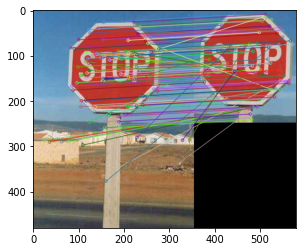

# of keypoints: 124
common: [(2, 1, 2, 1)]
most_common:,  [2 1 2 1]
homography_matrices: [array([[1.00245800e+00, 2.85128448e-03, 6.48307133e+01],
       [5.26290434e-05, 1.00312318e+00, 1.68939811e+01],
       [8.62066941e-06, 8.55458887e-06, 1.00000000e+00]])]


[array([[ 64.83071 ,  16.893982],
        [289.82162 ,  16.873095],
        [289.91348 , 264.60574 ],
        [ 65.399086, 265.1061  ]], dtype=float32)]

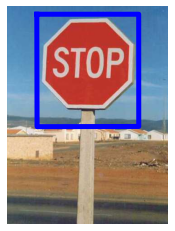

In [153]:
reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop1.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)

height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


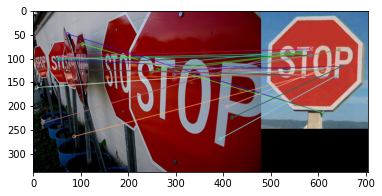

# of keypoints: 28
common: [(3, 1, 1, 3)]
most_common:,  [3 1 1 3]
homography_matrices: [array([[ 6.57994008e-01, -3.10527307e-01,  1.82426408e+02],
       [-6.71585382e-02,  1.61793258e+00, -4.06781039e+01],
       [-1.94389923e-03, -5.09960796e-04,  1.00000000e+00]])]


[array([[182.4264  , -40.678104],
        [587.3831  , -99.15842 ],
        [581.13696 , 792.05914 ],
        [120.67779 , 412.77264 ]], dtype=float32)]

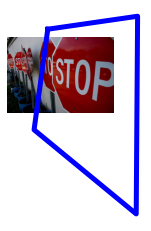

In [154]:
reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop2.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)




height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


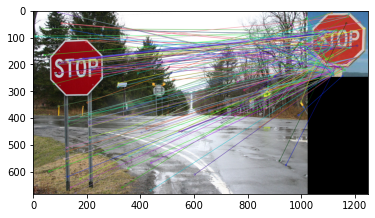

# of keypoints: 175
common: [(2, 2, 1, 1), (2, 2, 2, 1)]
most_common:,  [2 2 1 1]
homography_matrices: [array([[ 1.15658299e+00,  5.49681111e-02,  3.02600122e+01],
       [ 2.22199044e-02,  1.07160986e+00,  1.03766847e+02],
       [ 3.48407013e-04, -7.63162510e-05,  1.00000000e+00]]), array([[-3.56968815e+00, -2.61209402e+00,  9.34584611e+02],
       [-1.26609942e+00, -9.22123918e-01,  3.31835148e+02],
       [-3.80873857e-03, -2.78886633e-03,  1.00000000e+00]])]


[array([[ 30.260012, 103.766846],
        [269.37448 , 100.85977 ],
        [287.0536  , 353.5044  ],
        [ 44.73885 , 376.65482 ]], dtype=float32),
 array([[934.5846 , 331.83514],
        [918.6972 , 328.33337],
        [941.28656, 331.24734],
        [930.0306 , 334.50522]], dtype=float32)]

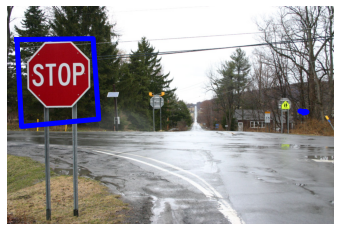

In [155]:

reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop3.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)





height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


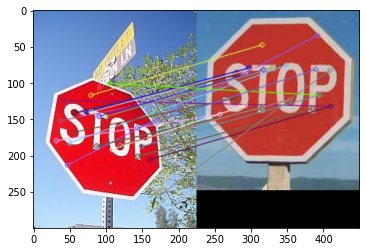

# of keypoints: 26
common: [(3, 1, 1, 3)]
most_common:,  [3 1 1 3]
homography_matrices: [array([[ 9.40333825e-01, -1.03313810e-01,  1.31708848e+01],
       [ 4.28487518e-01,  5.90440081e-01,  6.05397843e+01],
       [ 1.16101513e-03, -1.09687961e-03,  1.00000000e+00]])]


[array([[ 13.170885,  60.539783],
        [178.1961  , 124.44176 ],
        [201.29773 , 306.6902  ],
        [-17.103554, 284.3082  ]], dtype=float32)]

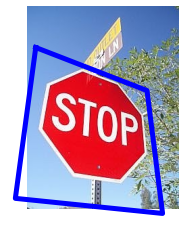

In [156]:
reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop4.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)





height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


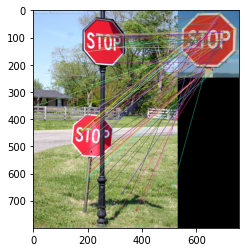

# of keypoints: 99
common: [(2, 2, 2, 2), (2, 1, 2, 1)]
most_common:,  [2 2 2 2]
homography_matrices: [array([[ 7.57676543e-01,  6.47006330e-02,  1.29106385e+02],
       [-8.88302081e-02,  1.04560567e+00,  3.66010712e+02],
       [-3.12722059e-04,  4.87826369e-04,  1.00000000e+00]]), array([[ 1.41671017e+00,  5.92629259e-01,  1.36837836e+02],
       [ 2.11563697e-01,  1.44846112e+00, -1.78419903e+01],
       [ 1.14991252e-03,  2.24076228e-03,  1.00000000e+00]])]


[array([[129.10638, 366.0107 ],
        [322.2585 , 372.2138 ],
        [300.42242, 576.1693 ],
        [129.48672, 557.8337 ]], dtype=float32),
 array([[136.83783 , -17.84199 ],
        [361.95013 ,  23.642746],
        [332.0969  , 214.37927 ],
        [182.43121 , 219.43459 ]], dtype=float32)]

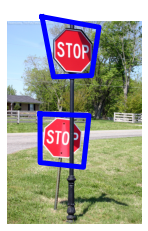

In [157]:
reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop5.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)





height, 781
width: 944
corner_vertices: [[[  0.   0.]]

 [[944.   0.]]

 [[944. 781.]]

 [[  0. 781.]]]


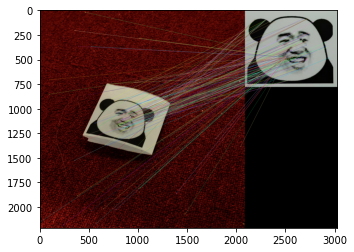

# of keypoints: 150
common: [(3, 2, 1, 2)]
most_common:,  [3 2 1 2]
homography_matrices: [array([[ 6.21064215e-01, -2.62688642e-01,  6.21478837e+02],
       [ 1.47400394e-01,  5.02670843e-01,  8.07853304e+02],
       [-2.44008147e-05, -4.01123292e-05,  1.00000000e+00]])]


[array([[ 621.4788 ,  807.85333],
        [1236.2395 ,  969.3271 ],
        [1060.2405 , 1416.5942 ],
        [ 429.78314, 1239.2626 ]], dtype=float32)]

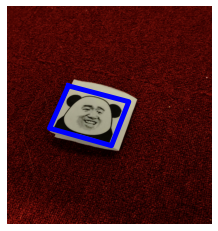

In [158]:
reference_image = imread('panda/panda_reference.jpeg')
input_image = imread('panda/panda1.jpeg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)

height, 781
width: 944
corner_vertices: [[[  0.   0.]]

 [[944.   0.]]

 [[944. 781.]]

 [[  0. 781.]]]


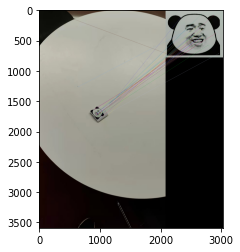

# of keypoints: 34
common: [(3, 3, 2, 3)]
most_common:,  [3 3 2 3]
homography_matrices: [array([[ 2.11705644e-01, -1.50851749e-01,  9.68394287e+02],
       [ 2.98176352e-01,  2.03058591e-01,  1.55223746e+03],
       [ 6.93769018e-05,  4.18612920e-05,  1.00000000e+00]])]


[array([[ 968.3943, 1552.2374],
        [1096.4368, 1721.0043],
        [ 956.5135, 1814.1787],
        [ 823.6509, 1656.6638]], dtype=float32)]

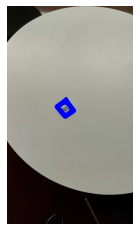

In [159]:
reference_image = imread('panda/panda_reference.jpeg')
input_image = imread('panda/panda3.jpeg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)

height, 781
width: 944
corner_vertices: [[[  0.   0.]]

 [[944.   0.]]

 [[944. 781.]]

 [[  0. 781.]]]


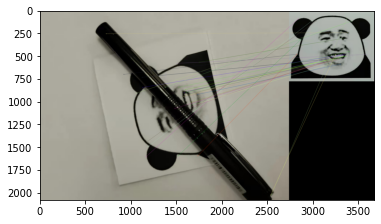

# of keypoints: 33
common: [(3, 3, 1, 2)]
most_common:,  [3 3 1 2]
homography_matrices: [array([[-3.34908855e-01,  1.38815527e+00,  1.11161625e+03],
       [-1.35187010e+00, -2.85392140e-01,  1.86944481e+03],
       [-1.53962294e-05,  2.76839205e-05,  1.00000000e+00]])]


[array([[1111.6162 , 1869.4448 ],
        [ 807.1941 ,  602.02936],
        [1866.3843 ,  367.78168],
        [2149.2954 , 1611.7067 ]], dtype=float32)]

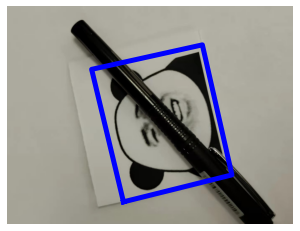

In [160]:
reference_image = imread('panda/panda_reference.jpeg')
input_image = imread('panda/panda4.jpeg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)

height, 781
width: 944
corner_vertices: [[[  0.   0.]]

 [[944.   0.]]

 [[944. 781.]]

 [[  0. 781.]]]


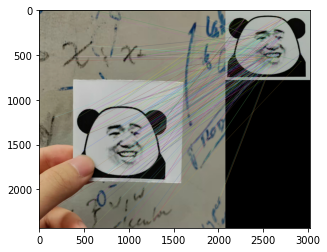

# of keypoints: 190
common: [(1, 2, 1, 3), (2, 2, 1, 3)]
most_common:,  [1 2 1 3]
homography_matrices: [array([[1.21320020e+00, 7.79686707e-02, 3.55903501e+02],
       [4.15085792e-02, 1.33409604e+00, 9.83360510e+02],
       [8.79614355e-06, 8.17451570e-05, 1.00000000e+00]]), array([[ 1.04608553e+00,  7.51520104e-02,  3.94164921e+02],
       [-1.05928407e-01,  1.27628868e+00,  1.00788738e+03],
       [-9.16572318e-05,  8.50589402e-05,  1.00000000e+00]])]


[array([[ 355.9035 ,  983.36053],
        [1488.8021 , 1014.1238 ],
        [1456.9446 , 1925.5518 ],
        [ 391.78436, 1903.7485 ]], dtype=float32),
 array([[ 394.16492, 1007.8874 ],
        [1512.5415 ,  993.8864 ],
        [1469.8987 , 1943.7285 ],
        [ 424.64877, 1879.7924 ]], dtype=float32)]

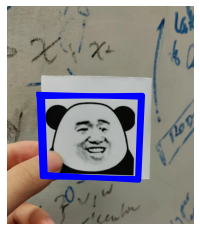

In [161]:
reference_image = imread('panda/panda_reference.jpeg')
input_image = imread('panda/panda5.jpeg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)

height, 781
width: 944
corner_vertices: [[[  0.   0.]]

 [[944.   0.]]

 [[944. 781.]]

 [[  0. 781.]]]


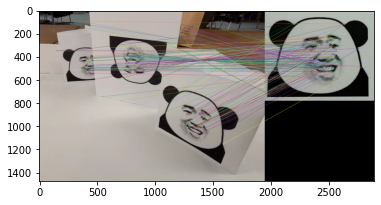

# of keypoints: 187
common: [(2, 2, 1, 3), (2, 2, 2, 2), (3, 2, 2, 3)]
most_common:,  [2 2 2 2]
homography_matrices: [array([[5.46172160e-01, 1.79500219e-01, 1.57655656e+02],
       [1.38344110e-02, 6.20426449e-01, 2.90928052e+02],
       [7.77942227e-05, 3.01698639e-04, 1.00000000e+00]]), array([[-4.71430604e-01, -1.06658125e-01,  1.07212246e+03],
       [-5.02177892e-02, -6.06801601e-01,  7.01069421e+02],
       [ 5.81816266e-05, -1.51792946e-04,  1.00000000e+00]]), array([[ 2.86381581e-01,  3.08396735e-01,  1.05520638e+03],
       [ 5.10992624e-02,  9.42071824e-01,  5.46106367e+02],
       [-2.99982057e-04,  3.38813808e-04,  1.00000000e+00]])]


[array([[157.65565, 290.92804],
        [627.1832 , 283.19083],
        [621.38416, 602.36975],
        [241.048  , 627.6015 ]], dtype=float32),
 array([[1072.1224 ,  701.0694 ],
        [ 594.4431 ,  619.63153],
        [ 580.7428 ,  191.96596],
        [1121.8138 ,  257.70883]], dtype=float32),
 array([[1055.2064 ,  546.1064 ],
        [1849.2178 ,  829.14343],
        [1596.0461 , 1355.2688 ],
        [1024.8698 , 1013.64124]], dtype=float32)]

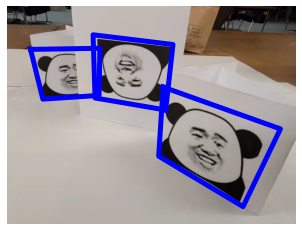

In [162]:
reference_image = imread('panda/panda_reference.jpeg')
input_image = imread('panda/panda2.jpeg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)